In [1]:
import os
import glob

import numpy as np                         
import xarray as xr
import nc_time_axis

import matplotlib.pyplot as plt 

import cartopy.crs as ccrs
import cartopy.mpl.gridliner as gridliner
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
path = '/home/innag3580/phase1_CONDA/'

# Load data events and their temporal location
data = np.genfromtxt(path+'current/events_dens_spg.csv', delimiter=',', names=True, dtype=None)

# Accessing columns by name
member_numbers = data['Index']
events = data['Values']
member_names = np.zeros(len(member_numbers))

# set periods
before = 50*12 #!!!! for cummulative integration
after = 20*12

# find file names 
def find_corresponding_file_name(vvel_number_to_find):
    with open(path+'timeseries/order.txt', 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

# Sea Level Pressure
- Choose relevant area
- Get event period for each member for 3$\sigma$ events  for 70 years (add ten years to beginning)
- Compute annual or winter composite 
- Get Labrador sea level pressure
- Compute anomaly composite

# Get relevant area

**Hurrell North Atlantic Oscillation (NAO) Index (PC-based)**

The principal component (PC)-based indices of the North Atlantic Oscillation (NAO) are the time series of the leading Empirical Orthogonal Function (EOF) of SLP anomalies over the Atlantic sector, 20°-80°N, 90°W-40°E. 

https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based

In [33]:
psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_1301.019.nc'
ds_plot = xr.open_dataset(psl_file).isel(time=0)

slice1 = ds_plot.isel(lat=slice(120, 180), lon=slice(215, 288))  # Part one from 225 to 290
slice2 = ds_plot.isel(lat=slice(120, 180), lon=slice(0, 30))    # Part two from 0 to 10

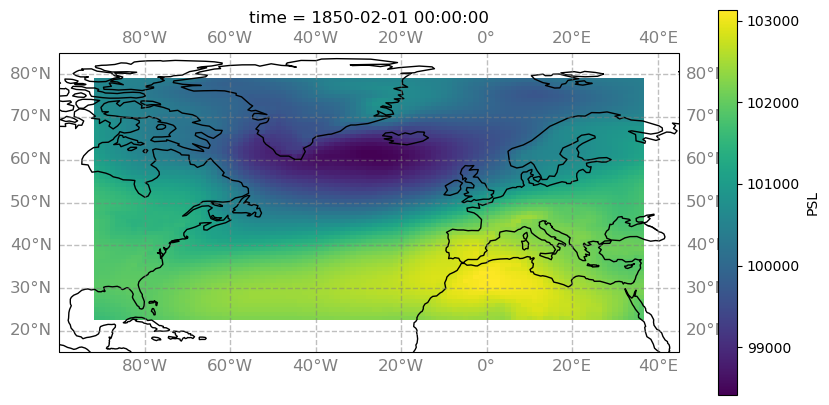

In [34]:
vmin = min(slice1.PSL.min(), slice2.PSL.min())
vmax = max(slice1.PSL.max(), slice2.PSL.max())

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

slice1.PSL.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap='viridis', cbar_kwargs={'label': 'PSL'})
slice2.PSL.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap='viridis', add_colorbar=False)

ax.set_extent([-100, 45, 15, 85], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 12, 'color': 'gray'}
gl.ylabel_style = {'size': 12, 'color': 'gray'}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()

**Dealing with zero meridian**

the longitudinal slice I am interesed in is slpit by the 0 meridian. This means we have two slices, 0-30 and 215-288 respectively. By rolling minus 20 lon I can move them into one consecutive slice. the resulting slice will be: (215-30) - 288

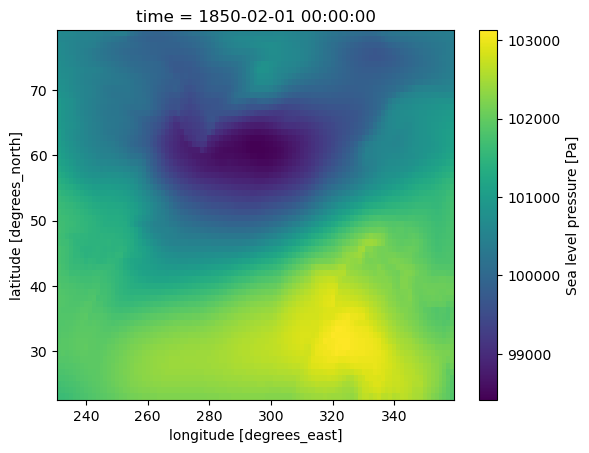

In [35]:
ds = xr.open_dataset(psl_file).isel(time=0).roll(lon=-30)
ds = ds.isel(lat=slice(120, 180), lon=slice(215-30, 288))
ds.PSL.plot()

# Choose time average

Annual mean

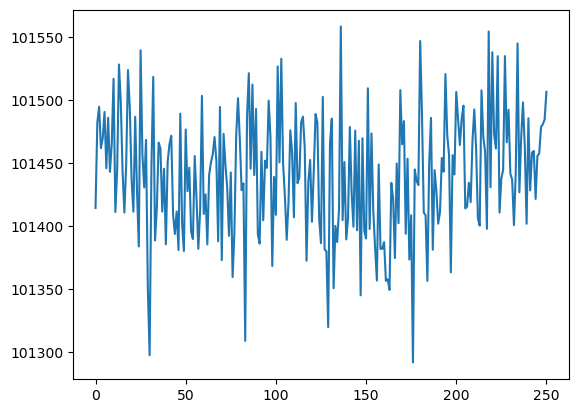

In [36]:
psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_1301.019.nc'
ds = xr.open_dataset(psl_file).roll(lon=-30).isel(lat=slice(120,180),lon=slice(215-30,288))
ds = ds.resample(time='A').mean(dim='time')
annual_mean = ds.PSL.mean(dim=['lat', 'lon']).values[:-1]

plt.plot(annual_mean)

Winter Mean

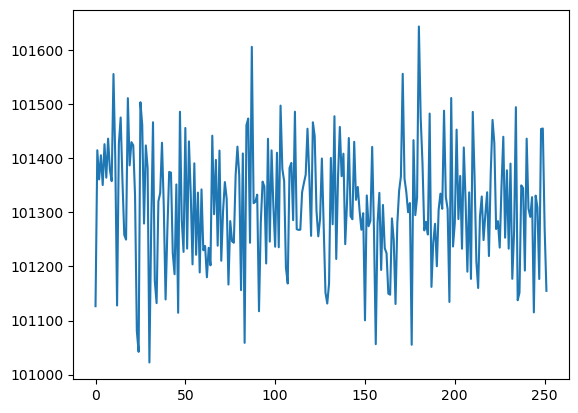

In [37]:
psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_1301.019.nc'
ds_winter = xr.open_dataset(psl_file).roll(lon=-30).isel(lat=slice(120,180),lon=slice(215-30,288))
monthly_average = ds_winter.sel(time=((ds_winter['time.month'] == 12) | (ds_winter['time.month'] == 1) | (ds_winter['time.month'] == 2))).resample(time='A').mean(dim='time')
winter_mean = monthly_average.PSL.mean(dim=['lat', 'lon']).values

plt.plot(winter_mean)


To compute annual mean: `mean = annual`?

To compute winter mean: `mean = winter`

In [6]:
mean = 'winter'

# SELECT TIME RANGE

In [38]:
for i in range(0, len(member_numbers)):
    # define entire time range for event
    member = find_corresponding_file_name(member_numbers[i])[5:]
    
    # Check if there are enough time steps for 'before', else set it to the maximum available
    if events[i] >= 50:
        before = 50*12
    else:
        before = events[i]*12
    
    event = events[i]*12
    period_start = event-before
    period_end = event+after
    
    print('computation member '+member+' started')

    time = slice(period_start, period_end)

    psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_'+member

    ds = xr.open_dataset(psl_file).roll(lon=-30).isel(lat=slice(120,180),lon=slice(215-30,288))
    ds = ds.isel(time=time)
    if 'time_bound' in ds.variables:
        ds = ds.drop_vars('time_bound')

    ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/psl_monthly_composite_'+member)

    print(member+' saved')

computation member 1301.019.nc started
1301.019.nc saved
computation member 1231.001.nc started
1231.001.nc saved
computation member 1281.012.nc started
1281.012.nc saved
computation member 1301.001.nc started
1301.001.nc saved
computation member 1281.017.nc started
1281.017.nc saved
computation member 1231.020.nc started
1231.020.nc saved
computation member 1231.004.nc started
1231.004.nc saved
computation member 1281.010.nc started
1281.010.nc saved
computation member 1281.020.nc started
1281.020.nc saved
computation member 1301.015.nc started
1301.015.nc saved
computation member 1281.015.nc started
1281.015.nc saved
computation member 1231.003.nc started
1231.003.nc saved
computation member 1251.010.nc started
1251.010.nc saved


# COMPUTE 70 YEAR MONTHLY COMPOSITES

this is tricky because one hast to take into account the members where 

In [42]:
psl_files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/psl_monthly_composite_*.nc'))

In [43]:
var_months = []
for t in range(70*12):
    var_month = []
    for i in range(len(psl_files)):
        try:
            ds = xr.open_dataset(psl_files[i])
        except ValueError as e:
            continue
            
        

        ds_file = ds['PSL'].isel(time=t)
        var_month.append(ds_file)

    ds_comp = xr.concat(var_month, dim='file').mean(dim='file')
    var_months.append(ds_comp)
    
    if t % 120 == 0:
        print(f"computed year {t // 12 + 1}.")


ds_var_annual = xr.concat(var_months, dim='time')

ds_var_annual.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/PSL_monthly_composite.nc')

IndexError: index 720 is out of bounds for axis 0 with size 720

# Get Labrador sea level pressure

In [44]:
psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_1301.019.nc'
ds_plot = xr.open_dataset(psl_file).isel(time=0)

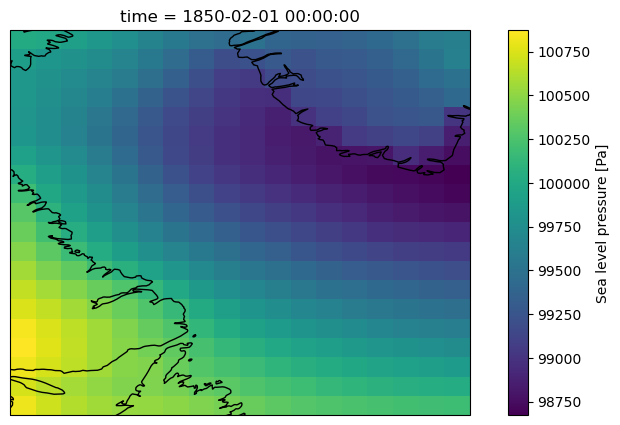

In [53]:
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ds_plot.PSL.isel(lat=slice(147, 167), lon=slice(237, 255)).plot(ax=ax, transform=ccrs.PlateCarree())

plt.show()

# PERIOD COMPOSITES

In [12]:
psl_anomalies  = []

for i in range(len(psl_files)):
    try:
        ds = xr.open_dataset(psl_files[i])
        print(f"{psl_files[i]} exists")
        # Do further processing with the dataset 'ds' if needed
    except ValueError as e:
        print(f"Error opening dataset from file {files[i]}: {e}")
        # Handle the exception, for example, continue with the next file
        continue
    
    # TEMP
    period1_avg = ds['PSL'].isel(time=slice(0*12,40*12)).mean(dim='time')  
    period2_avg = ds['PSL'].isel(time=slice(40*12,59*12)).mean(dim='time')
    difference = period2_avg - period1_avg
    psl_anomalies.append(difference)

psl_anomaly = xr.concat(psl_anomalies, dim='file').mean(dim='file')

psl_anomaly.to_netcdf(os.path.expanduser('~/phase1_CONDA/')+'/results/composites/psl_anomaly.nc')


/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1231.001.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1231.003.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1231.004.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1231.020.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1251.010.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.010.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.012.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.015.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.017.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1281.020.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/DJF_psl_composite_1301.00